## This Notebook  explores fan historical transactions for Ticketing products and is used to identify different customer personas within our fan base
<font color=blue> Questions we would like to know:</font>

<font color=blue> What kind of customers purchased our products?</font>
<font color=blue> What is the average spend, # of products, # of tickets, # of
    events purchased for each customer persona?:</font>


#### Importing packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import psycopg2
import sys
# from sqlalchemy import create_engine
import os
import subprocess
import datetime as dt
import requests
import lxml.html as lh
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
# import pyarrow.parquet as pq
# import boto3
# from pathlib import Path 
# from dotenv import load_dotenv, find_dotenv
# load_dotenv(find_dotenv())
# env_path = './.env'
# #env_path =  Path('/home/ec2-user/')
# load_dotenv(dotenv_path=env_path)
# postgres_user = os.environ['PSQL_USERNAME']
# postgres_pw = os.environ['PSQL_PASSWORD']
# postgres_url = os.environ['PSQL_URL']
# redshift_user = os.environ['REDSHIFT_USERNAME']
# redshift_pw = os.environ['REDSHIFT_PASSWORD']
# redshift_url = os.environ['REDSHIFT_URL']
%matplotlib inline 

#### This block makes the connection to postgres db 

In [2]:

# conn_string = "host='"+postgres_url+"' dbname='experience' user='"+postgres_user+"' password='"+postgres_pw+"'"
# conn = psycopg2.connect(conn_string)
# cursor = conn.cursor()

#### This block makes the connection to Redshift db

In [3]:

# red_engine = create_engine('postgresql://'+redshift_user+':'+redshift_pw+'@'+redshift_url)
# conn_red = red_engine.raw_connection()
# cur = conn_red.cursor()

####  Pulling in data from analytics schema on Redshift. The data is hard-coded from 3/1/2019 to 3/1/2020 for all fans that purchased products from us 1 year prior to Covid Pandemic

#### This sql query is run on the Redshift database to query the data  used for this analysis
#### The query below includes personal data but will be filtered out, so no personably identifiable information is in the analytics dataframes for this analysis

In [4]:

# sql_statement="""

# /*  Query to pull data from the analytics schema*/

# with pass_returns as(

# select segment,partner,group_type_id,group_id,fan_id,email,transaction_type_name,sum(credit_recieved) as pass_credit_given,
#        sum(credit_recieved)/count(distinct event_id)::float as pass_avg_return_credit,
#        count(distinct transaction_id)as pass_return_transactions,count(distinct event_id) as num_pass_return_events,
#        sum(fans_impacted) as pass_return_tickets_total,sum(fans_impacted)/count(distinct event_id)::float as avg_num_pass_return_tickets,
#        max(fans_impacted) as max_pass_return_group_size,min(fans_impacted) as min_pass_return_group_size


#        from mart.pass_transactions
# where  transaction_type in(2) and expapp_email_flag=0
# and event_date between '2019-03-01' and '2020-03-01'
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
# group by 1,2,3,4,5,6,7),

# guesttickets as(
# select segment,partner,group_id,fan_id,email,
#        sum(fans_impacted) as pass_guest_tickets,count(distinct event_id) as num_guest_ticket_events,
#        sum(accepted_fans_impacted) as pass_guest_ticket_accepted_tickets,
#        coalesce(sum(accepted_fans_impacted),0)/sum(fans_impacted)::float as pass_guest_ticket_acceptance
# from mart.pass_transactions pt
# where transaction_type=6 and active_filter=1 and expapp_email_flag=0  --and requires_acceptance_flag=1 and
# and event_date between '2019-03-01' and '2020-03-01'
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
# group by 1,2,3,4,5),

# pass_original as(
# select segment,partner,group_id,fan_id,email,count(distinct event_id) as num_of_pass_events,
#        count(distinct transaction_id) as pass_original_transactions,
#        coalesce(sum(accepted_transactions),0) as pass_original_accepted_transactions,
#        sum(fans_impacted) as pass_original_tickets,
#        coalesce(sum(accepted_fans_impacted),0) as pass_original_accepted_tickets,
#        coalesce(sum(accepted_fans_impacted),0)/sum(fans_impacted)::float as pass_original_ticket_acceptance

# from mart.pass_transactions pt
# where transaction_type=0 and active_filter=1 and expapp_email_flag=0 and requires_acceptance_flag=1
# and event_date between '2019-03-01' and '2020-03-01'
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
# group by 1,2,3,4,5),

# linkage as(

# select distinct segment,partner,group_type_id,group_id,fan_id,email,
#        coalesce(pass_times_linked,0)  as pass_times_linked,
#        coalesce(pass_total_linked_group_size,0)  as pass_total_linked_group_size,
#        coalesce(pass_linked_events,0)  as pass_linked_events,
#        coalesce(pass_avg_linked_group_size,0)  as pass_avg_linked_group_size,

#        coalesce(pass_one_times_linked,0) as pass_one_times_linked,
#        coalesce(pass_one_total_linked_group_size,0)  as pass_one_total_linked_group_size,
#        coalesce(pass_one_linked_events,0)  as pass_one_linked_events,
#        coalesce(pass_one_avg_linked_group_size,0)  as pass_one_avg_linked_group_size,

#        coalesce(pass_select_times_linked,0) as pass_select_times_linked,
#        coalesce(pass_select_total_linked_group_size,0)  as pass_select_total_linked_group_size,
#        coalesce(pass_select_linked_events,0)  as pass_select_linked_events,
#        coalesce(pass_select_avg_linked_group_size,0)  as pass_select_avg_linked_group_size



# from(
# select segment,partner,group_type_id,group_id,fan_id,email,
#        case when product_key in (3) then sum(times_linked) end as pass_times_linked,
#        case when product_key in (3) then sum(total_linked_group_size) end as pass_total_linked_group_size,
#        case when product_key in (3) then sum(num_of_events) end as pass_linked_events,
#        case when product_key in (3) then sum(avg_linked_group_size) end as pass_avg_linked_group_size,
#        case when product_key in (12) then sum(times_linked) end as pass_one_times_linked,
#        case when product_key in (12) then sum(total_linked_group_size) end as pass_one_total_linked_group_size,
#        case when product_key in (12) then sum(num_of_events) end as pass_one_linked_events,
#        case when product_key in (12) then sum(avg_linked_group_size) end as pass_one_avg_linked_group_size,

#        case when product_key in (13) then sum(times_linked) end as pass_select_times_linked,
#        case when product_key in (13) then sum(total_linked_group_size) end as pass_select_total_linked_group_size,
#        case when product_key in (13) then sum(num_of_events) end as pass_select_linked_events,
#        case when product_key in (13) then sum(avg_linked_group_size) end as pass_select_avg_linked_group_size




#        from(
# select segment,partner,group_type_id,group_id,fan_id,email,product_key,count(distinct tuc_link_id) as times_linked,
#        sum(swf_fans_impacted) as total_linked_group_size,count(distinct event_id) as num_of_events,
#        sum(swf_fans_impacted)/count(distinct event_id)::float as avg_linked_group_size

#     from mart.pass_linking
# where expapp_email_flag=0 and
# event_date between '2019-03-01' and '2020-03-01'
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
#     group by 1,2,3,4,5,6,7)subq1
#     group by 1,2,3,4,5,6,product_key)
#     subq2),



# ft_returns as(

# select segment,partner,fan_id,fan_email,group_id,group_type_id,
# count(distinct game_id) as num_fluid_ticket_return_games,
# sum(credit_per_seat) as fluid_ticket_return_credit,count(seat_id) as ft_returned_seats,
# sum(credit_per_seat)/count(seat_id)::float as avg_return_credit_per_seat,
# sum(credit_per_seat)/count(distinct game_id)::float as avg_return_credit_per_game
# from(
# select distinct ft.team as partner,ft.league as segment,ft.fan_id,ft.fan_email,
# gr.group_id,gr.group_type_id,ft.game_start_time,credit_per_seat,seat_id,game_id

# from mart.fluid_ticket_returns as ft
# left join mart.event e on ft.game_id=e.event_id
# left join mart."group" gr on e.group_id=gr.group_id
# left join mart.venue v on e.venue_id=v.venue_id
# where fan_email not like'%expapp%' --and fan_email ='abicompanies@aol.com'
# and ft.game_start_time between '2019-03-01' and '2020-03-01')subq1
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
# group by 1,2,3,4,5,6),

# --all transactions part

# all_trans as(
# select fan_id,fan_email,group_id,group_type_id,fan_group,segment,partner,
#        --current_date - cast('25 month' as interval as Pullback_date,
#        --current_date - cast('1 month' as interval) as Cutoff_date,'24 month' as History_summary,
#        '2019-03-01'::date as Start_Time,'2020-03-01'::date as End_Time,
#        sum(coalesce(upgrades_gross_sales,0)) as upgrades_gross_sales,
#        sum(coalesce(upgrades_net_sales,0)) as upgrades_net_sales,
#        sum(coalesce(upgrades_gross_sales,0))-sum(coalesce(upgrades_net_sales,0)) as upgrade_total_discounts,
#        sum(coalesce(upgrades_avg_gross_sales,0)) as upgrades_avg_gross_sales,
#        sum(coalesce(upgrades_avg_net_sales,0)) as upgrades_avg_net_sales,
#        sum(coalesce(Num_upgrade_transactions,0)) as num_upgraded_events,
#        sum(coalesce(num_upgraded_events,0)) as num_upgrade_transactions,
#        sum(coalesce(upgrade_points_used,0)) as upgrade_points_used,
#        sum(coalesce(upgrades_max_group_size,0)) as upgrades_max_group_size,
#        --sum(coalesce(upgrades_min_group_size,0)) as upgrades_min_group_size,
#        sum(coalesce(avg_upgrade_group_size,0)) as upgrade_avg_group_size,
#        sum(coalesce(upgrades_total_group_size,0)) as upgrades_total_group_size,

#        sum(coalesce(exp_merch_gross_sales,0)) as exp_merch_gross_sales,
#        sum(coalesce(exp_merch_net_sales,0)) as exp_merch_net_sales,
#        sum(coalesce(exp_merch_gross_sales,0))-sum(coalesce(exp_merch_net_sales,0)) as exp_merch_total_discounts,
#        sum(coalesce(exp_merch_avg_gross_sales,0)) as exp_merch_avg_gross_sales,
#        sum(coalesce(exp_merch_avg_net_sales,0)) as exp_merch_avg_net_sales,
#        sum(coalesce(Num_exp_merch_transactions,0)) as Num_exp_merch_transactions,
#        sum(coalesce(exp_merch_points_used,0)) as exp_merch_points_used,
#        sum(coalesce(exp_merch_total_items,0)) as exp_merch_total_items,
#        sum(coalesce(avg_exp_merch_total_items,0)) as exp_merch_avg_items,
# --left off number of events and max an minimum since combining two products

#        sum(coalesce(pass_guest_tickets_gross_sales,0)) as pass_guest_tickets_gross_sales,
#        sum(coalesce(pass_guest_tickets_net_sales,0)) as pass_guest_tickets_net_sales,
#        sum(coalesce(pass_guest_tickets_gross_sales,0))-sum(coalesce(pass_guest_tickets_net_sales,0)) as pass_guest_ticket_total_discounts,
#        sum(coalesce(pass_guest_tickets_avg_gross_sales,0)) as pass_guest_tickets_avg_gross_sales,
#        sum(coalesce(pass_guest_tickets_avg_net_sales,0)) as pass_guest_tickets_avg_net_sales,
#        sum(coalesce(num_pass_guest_ticket_events,0)) as num_pass_guest_ticket_events,
#        sum(coalesce(Num_pass_guest_ticket_transactions,0)) as num_pass_guest_ticket_transactions,
#        sum(coalesce(pass_guest_ticket_max_group_size,0)) as pass_guest_ticket_max_group_size,
#        --sum(coalesce(pass_guest_ticket_min_group_size,0)) as pass_guest_ticket_min_group_size,
#        sum(coalesce(avg_pass_guest_ticket_group_size,0)) as pass_guest_ticket_avg_group_size,
#        sum(coalesce(pass_guest_ticket_total_tickets,0)) as pass_guest_ticket_total_tickets,

#        sum(coalesce(fluid_ticket_add_tickets_gross_sales,0)) as fluid_ticket_add_tickets_gross_sales,
#        sum(coalesce(fluid_ticket_add_tickets_net_sales,0)) as fluid_ticket_add_tickets_net_sales,
#        sum(coalesce(fluid_ticket_add_tickets_gross_sales,0))-sum(coalesce(fluid_ticket_add_tickets_net_sales,0)) as fluid_ticket_add_ticket_total_discounts,
#        sum(coalesce(fluid_ticket_add_ticket_avg_gross_sales,0)) as fluid_ticket_add_ticket_avg_gross_sales,
#        sum(coalesce(fluid_ticket_add_ticket_avg_net_sales,0)) as fluid_ticket_add_ticket_avg_net_sales,
#         sum(coalesce(num_add_ticket_events,0)) as num_add_ticket_events,
#        sum(coalesce(Num_Add_Tickets_transactions,0)) as num_Add_Tickets_transactions,
#        sum(coalesce(add_ticket_max_group_size,0)) as fluid_ticket_add_ticket_max_group_size,
#        --sum(coalesce(add_ticket_min_group_size,0)) as fluid_ticket_add_ticket_min_group_size,
#        sum(coalesce(avg_add_ticket_group_size,0)) as fluid_ticket_add_ticket_avg_group_size,
#        sum(coalesce(fluid_ticket_add_ticket_total_group_size,0)) as fluid_ticket_add_ticket_total_tickets,

#        sum(coalesce(Pass_One_gross_sales,0)) as Pass_One_gross_sales,
#        sum(coalesce(Pass_One_net_sales,0))as Pass_One_net_sales,
#        sum(coalesce(Pass_One_gross_sales,0))-sum(coalesce(Pass_One_net_sales,0)) as pass_one_total_discounts,
#        sum(coalesce(pass_one_avg_gross_sales,0)) as pass_one_avg_gross_sales,
#        sum(coalesce(pass_one_avg_net_sales,0))as pass_one_avg_net_sales,
#        sum(coalesce(num_pass_one_events,0))as num_pass_one_events,
#        sum(coalesce(Num_Pass_one_transactions,0)) as Num_Pass_one_transactions,
#        sum(coalesce(pass_one_max_group_size,0)) as pass_one_max_group_size,
#        --sum(coalesce(pass_one_min_group_size,0)) as pass_one_min_group_size,
#        sum(coalesce(avg_pass_one_group_size,0)) as pass_one_avg_group_size,
#        sum(coalesce(pass_one_total_group_size,0)) as pass_one_total_group_size,

#        sum(coalesce(Pass_Select_Vouchers,0)) as Pass_Select_Vouchers,
#        sum(coalesce(pass_select_avg_vouchers,0)) as pass_select_avg_vouchers,
#        sum(coalesce(num_pass_select_events,0)) as num_pass_select_events,
#        sum(coalesce(Num_Pass_Select_transactions,0)) as num_Pass_Select_transactions,
#        sum(coalesce(pass_select_max_group_size,0)) as pass_select_max_group_size,
#        --sum(coalesce(pass_select_min_group_size,0)) as pass_select_min_group_size,
#     sum(coalesce(avg_pass_select_group_size,0)) as pass_select_avg_group_size,
#        sum(coalesce(pass_select_total_group_size,0)) as pass_select_total_group_size



# from(


# select fan_id,fan_email,group_id,group_type_id,fan_group,segment,partner,
#        case when product_key in(0) then max_group_size end as upgrades_max_group_size,
#        --case when product_key in(0) then min_group_size end as upgrades_min_group_size,
#        case when product_key in(3) then max_group_size end as Pass_guest_ticket_max_group_size,
#        --case when product_key in(3) then min_group_size end as Pass_guest_ticket_min_group_size,
#        case when product_key in(12) then max_group_size end as pass_one_max_group_size,
#        --case when product_key in(12) then min_group_size end as pass_one_min_group_size,
#        case when product_key in(13) then max_group_size end as pass_select_max_group_size,
#        --case when product_key in(13) then min_group_size end as pass_select_min_group_size,
#        case when product_key in(4) then max_group_size end as add_ticket_max_group_size,
#        --case when product_key in(4) then min_group_size end as add_ticket_min_group_size,
#        case when product_key in(0) then sum(gross) end as upgrades_gross_sales,
#        case when product_key in(0) then sum(net) end as upgrades_net_sales,
#        case when product_key in(0) then sum(gross)/sum(num_of_events)::float end as upgrades_avg_gross_sales,
#        case when product_key in(0) then sum(net)/sum(num_of_events)::float end as upgrades_avg_net_sales,
#        case when product_key in(0) then sum(num_of_transactions) end as Num_upgrade_transactions,
#        case when product_key in(0) then sum(num_of_events) end as num_upgraded_events,
#        case when product_key in(0) then sum(num_points_used) end as upgrade_points_used,
#        case when product_key in(0) then sum(total_group_size) end as upgrades_total_group_size,
#        case when product_key in(0) then sum(total_group_size)/sum(num_of_events)::float end as avg_upgrade_group_size,
#        case when product_key in(1,2)then sum(gross) end as exp_merch_gross_sales,
#        case when product_key in(1,2) then sum(net) end as exp_merch_net_sales,
#        case when product_key in(1,2) then sum(gross)/sum(num_of_events)::float end as exp_merch_avg_gross_sales,
#        case when product_key in(1,2) then sum(net)/sum(num_of_events)::float end as exp_merch_avg_net_sales,
#        case when product_key in(1,2) then sum(num_of_transactions) end as num_exp_merch_transactions,
#        case when product_key in(1,2) then sum(num_of_events) end as num_exp_merch_events,
#        case when product_key in (1,2) then sum(num_points_used) end as exp_merch_points_used,
#        case when product_key in (1,2) then sum(num_of_transactions) end as exp_merch_total_items ,--use transactions for group size
#        case when product_key in (1,2) then sum(num_of_transactions)/sum(num_of_events)::float end as avg_exp_merch_total_items ,

#        case when product_key in(3) then sum(gross) end as pass_guest_tickets_gross_sales,
#        case when product_key in(3) then sum(net) end as pass_guest_tickets_net_sales,
#        case when product_key in(3) then sum(gross)/sum(num_of_events)::float end as pass_guest_tickets_avg_gross_sales,
#        case when product_key in(3) then sum(net)/sum(num_of_events)::float end as pass_guest_tickets_avg_net_sales,
#        case when product_key in(3) then sum(num_of_transactions) end as Num_pass_guest_ticket_transactions,
#        case when product_key in(3) then sum(num_of_events) end as num_pass_guest_ticket_events,
#        case when product_key in(3) then sum(total_group_size) end as pass_guest_ticket_total_tickets,
#        case when product_key in(3) then sum(total_group_size)/sum(num_of_events)::float end as avg_pass_guest_ticket_group_size,

#        case when product_key in(4) then sum(gross) end as fluid_ticket_add_tickets_gross_sales,
#        case when product_key in(4) then sum(net) end as fluid_ticket_add_tickets_net_sales,
#        case when product_key in(4) then sum(gross)/sum(num_of_events)::float end as fluid_ticket_add_ticket_avg_gross_sales,
#        case when product_key in(4) then sum(net)/sum(num_of_events)::float end as fluid_ticket_add_ticket_avg_net_sales,
#        case when product_key in(4) then sum(num_of_transactions) end as Num_Add_Tickets_transactions,
#        case when product_key in(4) then sum(num_of_events) end as num_add_ticket_events,
#        case when product_key in(4) then sum(total_group_size) end as fluid_ticket_add_ticket_total_group_size,
#        case when product_key in(4) then sum(total_group_size)/sum(num_of_events)::float end as avg_add_ticket_group_size,
#        case when product_key in(12) then sum(gross) end as Pass_One_gross_sales,
#        case when product_key in(12) then sum(net) end as Pass_One_net_sales,
#        case when product_key in(12) then sum(gross)/sum(num_of_events)::float end as pass_one_avg_gross_sales,
#        case when product_key in(12) then sum(net)/sum(num_of_events)::float end as pass_one_avg_net_sales,
#        case when product_key in(12) then sum(num_of_transactions) end as Num_Pass_one_transactions,
#        case when product_key in(12) then sum(num_of_events) end as num_pass_one_events,
#        case when product_key in(12) then sum(total_group_size) end as pass_one_total_group_size,
#        case when product_key in(12) then sum(total_group_size)/sum(num_of_events)::float end as avg_pass_one_group_size,
#        case when product_key in(13) then sum(vouchers) end as Pass_Select_Vouchers,
#        case when product_key in(13) then sum(vouchers)/sum(num_of_events)::float end as pass_select_avg_vouchers,
#        case when product_key in(13) then sum(num_of_transactions) end as Num_Pass_Select_transactions,
#        case when product_key in(13) then sum(num_of_events) end as num_pass_select_events,
#        case when product_key in(13) then sum(total_group_size) end as pass_select_total_group_size,
#        case when product_key in(13) then sum(total_group_size)/sum(num_of_events)::float end as avg_pass_select_group_size


#  from(
# select fan_id,fan_email,group_id,fan_id||' - ' ||group_id as fan_group,at.segment,at.partner,
#        at.group_type_id,
#        --event_date,
#        product_key,sum(gross_sales) as gross,sum(net_sales) as net,sum(group_size) as total_group_size,
#        max(group_size)  as max_group_size,
#        min(group_size)  as min_group_size,
#        count(distinct event_id) as num_of_events,count(distinct payment_id) as num_of_transactions,
#        sum(comps) as comps, sum(vouchers) as vouchers,sum(points_used) as num_points_used

# from mart.all_transactions at
# where active_filter=1 and expapp_email_flag=0 and --fan_email='lukeshanahan@yahoo.com'  and group_id=1 and
# event_date between '2019-03-01' and '2020-03-01'
#     --(current_date - cast('25 month' as interval))and (current_date - cast('1 month' as interval))
# group by 1,2,3,4,5,6,7,8
# order by fan_group)subq1
# group by 1,2,3,4,5,6,7,product_key,max_group_size,min_group_size

#     )subq2
# group by 1,2,3,4,5,6,7,8,9)


# select *,
#        upgrade_fan + exp_merch_fan + pass_fan + pass_one_fan +pass_select_fan + fluid_ticket_fan as num_products_used

# from(

# select *,
#        case when num_upgrade_transactions>0 then 1 else 0 end as upgrade_fan,
#        case when Num_exp_merch_transactions>0 then 1 else 0 end as exp_merch_fan,
#        case when (pass_original_transactions>0) or (num_pass_guest_ticket_transactions>0) then 1 else 0 end as pass_fan,
#        case when Num_Pass_one_transactions >0 then 1 else 0 end as pass_one_fan,
#        case when num_Pass_Select_transactions >0 then 1 else 0 end as pass_select_fan,
#        case when (num_Add_Tickets_transactions >0) or (fluid_return_ticket_returned_seats>0) then 1 else 0 end as fluid_ticket_fan,
#        case when pass_times_linked>0 then 1 else 0 end as pass_linkage_user,
#        case when pass_one_times_linked>0 then 1 else 0 end as pass_one_linkage_user,
#        case when pass_select_times_linked>0 then 1 else 0 end as pass_select_linkage_user,
#        case when num_pass_guest_ticket_transactions >0 then 1 else 0 end as pass_guest_ticket_user,
#        case when pass_return_transactions > 0 then 1 else 0 end as pass_return_ticket_user,
#        case when num_Add_Tickets_transactions >0 then 1 else 0 end as fluid_ticket_add_ticket_user,
#        case when fluid_return_ticket_returned_seats > 0 then 1 else 0 end as fluid_ticket_return_ticket_user,

#        (upgrades_gross_sales+pass_one_gross_sales+pass_guest_tickets_gross_sales+
#         exp_merch_gross_sales+fluid_ticket_add_tickets_gross_sales) as total_gross_sales,

#        (upgrades_net_sales + Pass_One_net_sales + pass_guest_tickets_net_sales+
#         exp_merch_net_sales + fluid_ticket_add_tickets_net_sales) as total_net_sales,

#         (pass_return_total_credit_given + fluid_ticket_return_credit) as total_credit_given,

#        (upgrade_total_tickets + pass_guest_ticket_total_tickets + pass_one_total_tickets +
#         pass_original_tickets + fluid_ticket_add_ticket_total_tickets) as total_tickets,
#        (pass_return_tickets_total + fluid_return_ticket_returned_seats) as total_ticket_returns,

#        (num_upgrade_transactions + Num_Pass_one_transactions + num_pass_guest_ticket_transactions +
#            pass_original_transactions +num_exp_merch_transactions + num_Add_Tickets_transactions ) as total_transactions,

#        (num_pass_one_events + num_of_pass_events + num_pass_select_events + num_pass_guest_ticket_events +
#         num_add_ticket_events + num_upgraded_events) as total_events,

#        (pass_return_total_events + num_fluid_ticket_return_games) as total_events_returned



# from(
# select at.segment,at.partner,at.group_type_id,at.group_id,at.fan_id,at.fan_email,
#        at.fan_group,--at.Pullback_date,at.Cutoff_date,at.History_summary,
#        at.Start_Time,at.End_Time,at.upgrades_gross_sales,
#        at.upgrades_net_sales,upgrade_total_discounts,at.upgrades_avg_gross_sales,at.upgrades_avg_net_sales,
#        at.num_upgraded_events,at.num_upgrade_transactions,at.upgrade_points_used,at.upgrades_max_group_size,
#        at.upgrade_avg_group_size,at.upgrades_total_group_size as upgrade_total_tickets,
#        at.exp_merch_gross_sales,at.exp_merch_net_sales,at.exp_merch_total_discounts,
#        at.exp_merch_avg_gross_sales,at.exp_merch_avg_net_sales,at.Num_exp_merch_transactions,
#        at.exp_merch_points_used,at.exp_merch_total_items,at.exp_merch_avg_items,
#        coalesce(po.num_of_pass_events,0) as num_of_pass_events,
#        coalesce(po.pass_original_transactions,0) as pass_original_transactions,
#        coalesce(po.pass_original_accepted_transactions,0) as pass_original_accepted_transactions,
#        coalesce(po.pass_original_tickets,0) as pass_original_tickets,
#        coalesce(po.pass_original_accepted_tickets,0) as pass_original_accepted_tickets,
#        coalesce(po.pass_original_ticket_acceptance,0) as pass_original_ticket_acceptance,
#        at.pass_guest_tickets_gross_sales,at.pass_guest_tickets_net_sales,
#        at.pass_guest_ticket_total_discounts,at.pass_guest_tickets_avg_gross_sales,
#        at.pass_guest_tickets_avg_net_sales,at.num_pass_guest_ticket_transactions,
#        at.pass_guest_ticket_max_group_size,at.pass_guest_ticket_avg_group_size,at.pass_guest_ticket_total_tickets,
#        at.num_pass_guest_ticket_events,
#        coalesce(gt.pass_guest_ticket_accepted_tickets,0) as pass_guest_ticket_accepted_tickets ,

#        coalesce(gt.pass_guest_ticket_acceptance,0) as pass_guest_ticket_acceptance,
#        coalesce(pr.pass_return_transactions,0) as pass_return_transactions,
#        coalesce(pr.pass_return_tickets_total,0) as pass_return_tickets_total,
#        coalesce(pr.pass_credit_given,0) as pass_return_total_credit_given,
#        coalesce(pr.num_pass_return_events,0) as pass_return_total_events,
#        coalesce(pr.pass_avg_return_credit,0) as pass_avg_return_credit,
#        coalesce(pr.avg_num_pass_return_tickets,0) as avg_num_pass_return_tickets,
#        coalesce(pr.min_pass_return_group_size,0) as min_pass_return_tickets,
#        coalesce(pr.max_pass_return_group_size,0) as max_pass_return_tickets,
#        at.Pass_One_gross_sales,at.pass_one_net_sales,at.pass_one_total_discounts,
#        at.pass_one_avg_gross_sales,at.pass_one_avg_net_sales,at.num_pass_one_events,
#        at.Num_Pass_one_transactions,at.pass_one_max_group_size,at.pass_one_avg_group_size,
#        at.pass_one_total_group_size as pass_one_total_tickets,
#        at.Pass_Select_Vouchers,at.pass_select_avg_vouchers,at.num_pass_select_events,
#        at.num_Pass_Select_transactions,at.pass_select_max_group_size,at.pass_select_avg_group_size,
#        at.pass_select_total_group_size as pass_select_total_vouchers,
#        coalesce(l.pass_times_linked,0) as pass_times_linked,
#        coalesce(l.pass_total_linked_group_size,0) as pass_total_linked_group_size,
#        coalesce(l.pass_linked_events,0) as pass_linked_events,
#        coalesce(l.pass_avg_linked_group_size,0) as pass_avg_linked_group_size,

#        coalesce(l.pass_one_times_linked,0) as pass_one_times_linked,
#        coalesce(l.pass_one_total_linked_group_size,0) as pass_one_total_linked_group_size,
#        coalesce(l.pass_one_linked_events,0) as pass_one_linked_events,
#        coalesce(l.pass_one_avg_linked_group_size,0) as pass_one_avg_linked_group_size,

#        coalesce(l.pass_select_times_linked,0) as pass_select_times_linked,
#        coalesce(l.pass_select_total_linked_group_size,0) as pass_select_total_linked_group_size,
#        coalesce(l.pass_select_linked_events,0) as pass_select_linked_events,
#        coalesce(l.pass_select_avg_linked_group_size,0) as pass_select_avg_linked_group_size,
#        at.fluid_ticket_add_tickets_gross_sales,at.fluid_ticket_add_tickets_net_sales,
#        at.fluid_ticket_add_ticket_total_discounts,at.fluid_ticket_add_ticket_avg_gross_sales,
#        at.fluid_ticket_add_ticket_avg_net_sales,at.num_add_ticket_events,num_Add_Tickets_transactions,
#        at.fluid_ticket_add_ticket_max_group_size,at.fluid_ticket_add_ticket_avg_group_size,
#        at.fluid_ticket_add_ticket_total_tickets,
#        coalesce(ft.num_fluid_ticket_return_games,0) as num_fluid_ticket_return_games,
#        coalesce(ft.ft_returned_seats,0) as fluid_return_ticket_returned_seats,
#        coalesce(ft.fluid_ticket_return_credit,0) as  fluid_ticket_return_credit,
#        coalesce(ft.avg_return_credit_per_game,0) as fluid_ticket_avg_return_credit_per_game,
#        coalesce(ft.avg_return_credit_per_seat,0) as fluid_ticket_avg_return_credit_per_seat


#        from all_trans at
# left join pass_original po on at.fan_id=po.fan_id and at.group_id=po.group_id
# left join guesttickets gt on at.fan_id=gt.fan_id and at.group_id=gt.group_id
# left join pass_returns pr on at.fan_id=pr.fan_id and at.group_id=pr.group_id
# left join linkage l on at.fan_id=l.fan_id and at.group_id=l.group_id
# left join ft_returns ft on at.fan_id=ft.fan_id and at.group_id=ft.group_id)subq1)subq2

# ;
# """
# transactions = pd.read_sql(sql_statement, conn_red) 

#### Checking transactions dataframe, Over 121 columns but will reduce in next step to get only necesary variables for this analysis removing Personable Identifiable Info

In [5]:
# transactions.info()

###  Subsetting transactions dataframe for required columns only  -- Removing PII

#### (Subsetting dataframe "transactions" for only data needed for this analysis anonymizing the Teams and fan data)

In [6]:

# anal_data = transactions[["fan_id","segment","group_id", "group_type_id",\
#                           "upgrade_fan","exp_merch_fan","pass_fan","pass_one_fan",\
#                          "pass_select_fan","fluid_ticket_fan","pass_linkage_user",\
#                           "pass_one_linkage_user","pass_select_linkage_user",\
#                          "pass_guest_ticket_user","pass_return_ticket_user",\
#                           "fluid_ticket_add_ticket_user","fluid_ticket_return_ticket_user",\
#                          "total_gross_sales","total_net_sales","total_credit_given","total_tickets",\
#                           "total_transactions","total_events","num_products_used"]]


#### 23 Variables left after subsetting of Data and removal of PII

In [7]:
# anal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369744 entries, 0 to 369743
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   fan_id                           369744 non-null  int64  
 1   segment                          369744 non-null  object 
 2   group_id                         369744 non-null  int64  
 3   group_type_id                    369744 non-null  int64  
 4   upgrade_fan                      369744 non-null  int64  
 5   exp_merch_fan                    369744 non-null  int64  
 6   pass_fan                         369744 non-null  int64  
 7   pass_one_fan                     369744 non-null  int64  
 8   pass_select_fan                  369744 non-null  int64  
 9   fluid_ticket_fan                 369744 non-null  int64  
 10  pass_linkage_user                369744 non-null  int64  
 11  pass_one_linkage_user            369744 non-null  int64  
 12  pa

In [8]:
# anal_data.head()

,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,fluid_ticket_fan,...,pass_return_ticket_user,fluid_ticket_add_ticket_user,fluid_ticket_return_ticket_user,total_gross_sales,total_net_sales,total_credit_given,total_tickets,total_transactions,total_events,num_products_used
0,83025,NBA,1047,3,1,0,1,0,0,1,...,0,0,1,131.6,131.6,86.0,24.0,12,12,3
1,252070,NCAA BB,665,5,1,0,1,0,0,0,...,0,0,0,15.0,15.0,0.0,37.0,35,19,2
2,555476,NCAA BB,1161,5,0,0,1,0,0,0,...,0,0,0,10.0,10.0,0.0,20.0,20,20,1
3,886521,NCAA BB,665,5,1,0,1,0,0,0,...,1,0,0,44.0,0.0,64.8,62.0,39,16,2
4,906123,NBA,1047,3,0,0,1,1,0,1,...,0,1,1,8181.0,4225.0,1988.0,370.0,54,54,3


### For Clustering analysis removing rows where fans don't have purchase transactions for tickets , or events, since there are times that fans get free tickets and experiences and merchandise that don't involve financial transactions 

In [9]:

# #subsetting those without values of 0

# anal_data_trim = anal_data[(anal_data['total_net_sales']>0) &(anal_data['total_tickets'] >0)&(anal_data['total_events']>0)]

### This reduce the number of rows from 369,744 rows to 191,784 rows

#### Had to reset index after subset, notice column index that has old index values

In [10]:
# anal_data_trim = anal_data_trim.reset_index()
# anal_data_trim

,index,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,...,pass_return_ticket_user,fluid_ticket_add_ticket_user,fluid_ticket_return_ticket_user,total_gross_sales,total_net_sales,total_credit_given,total_tickets,total_transactions,total_events,num_products_used
0,0,83025,NBA,1047,3,1,0,1,0,0,...,0,0,1,131.6,131.6,86.0,24.0,12,12,3
1,1,252070,NCAA BB,665,5,1,0,1,0,0,...,0,0,0,15.0,15.0,0.0,37.0,35,19,2
2,2,555476,NCAA BB,1161,5,0,0,1,0,0,...,0,0,0,10.0,10.0,0.0,20.0,20,20,1
3,4,906123,NBA,1047,3,0,0,1,1,0,...,0,1,1,8181.0,4225.0,1988.0,370.0,54,54,3
4,5,1107319,NBA,1047,3,1,0,1,0,0,...,0,0,0,994.4,974.4,0.0,96.0,48,48,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191779,369732,4650029,NCAA BB,1652,5,0,0,0,1,0,...,0,0,0,10.0,10.0,0.0,2.0,1,1,1
191780,369733,5120718,MLB,24,1,1,0,0,0,0,...,0,0,0,106.0,106.0,0.0,4.0,1,1,1
191781,369736,2541881,LIVE NATION,149,12,1,0,0,0,0,...,0,0,0,40.0,40.0,0.0,2.0,1,1,1
191782,369737,4128436,NCAA BB,966,5,0,0,0,1,0,...,0,0,0,22.0,22.0,0.0,2.0,2,2,1


### To work off of the Remote Desktop and work on local machine exported analysis dataset to a CSV then reimported as a dataframe called "analysis_data"

In [11]:
# Export data to csv file

# anal_data_trim.to_csv("Analysis_Data_for_Clustering.csv",index=False)

In [12]:
# Importing data

analysis_data = pd.read_csv("/Users/gregsaunders/Documents/Analysis_Data_for_Clustering .csv")

In [13]:
analysis_data.tail()

,index,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,...,pass_return_ticket_user,fluid_ticket_add_ticket_user,fluid_ticket_return_ticket_user,total_gross_sales,total_net_sales,total_credit_given,total_tickets,total_transactions,total_events,num_products_used
191779,369732,4650029,NCAA BB,1652,5,0,0,0,1,0,...,0,0,0,10.0,10.0,0.0,2.0,1,1,1
191780,369733,5120718,MLB,24,1,1,0,0,0,0,...,0,0,0,106.0,106.0,0.0,4.0,1,1,1
191781,369736,2541881,LIVE NATION,149,12,1,0,0,0,0,...,0,0,0,40.0,40.0,0.0,2.0,1,1,1
191782,369737,4128436,NCAA BB,966,5,0,0,0,1,0,...,0,0,0,22.0,22.0,0.0,2.0,2,2,1
191783,369742,2396762,MLB,31,1,1,0,0,0,0,...,0,0,0,13.0,13.0,0.0,1.0,1,1,1


### Plot to see which segments have enough data to move forward with. 
<font color=blue> The segments:  NCAA Other, MLS, AUSFB, NFL , CONCERTS AND THEATRE, and MINOR LEAGUE have little purchase transactions in comparison to other Segments</font>


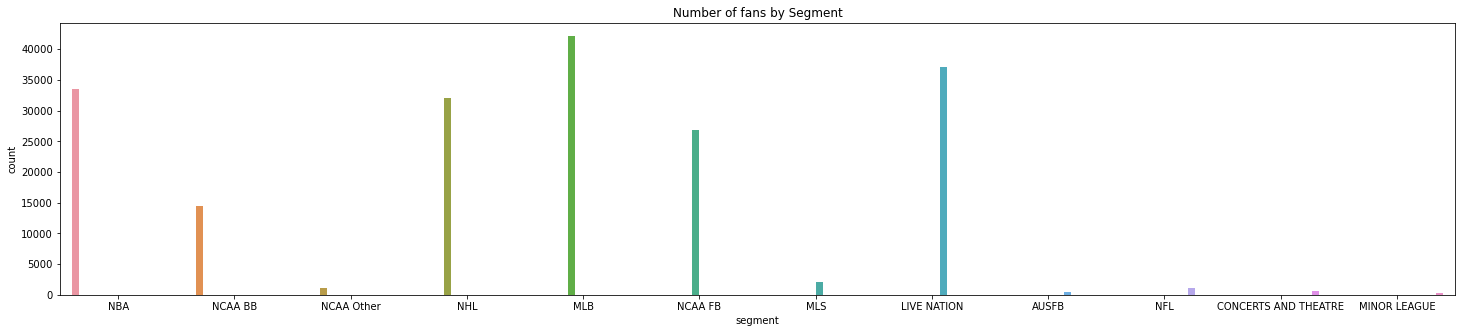

In [14]:
plt.figure(figsize=(25,5))
sns.countplot(x="segment", hue="segment", data=analysis_data)
plt.legend([],[], frameon=False)
plt.title('Number of fans by Segment')
plt.show()

### Looking at distributions of metrics using Seaborn Visualizations

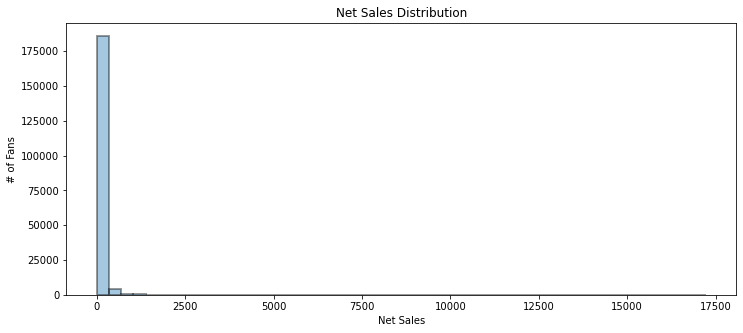

In [15]:
plt.figure(figsize=(12,5))
sns.distplot(analysis_data["total_net_sales"],hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Net Sales Distribution')
plt.xlabel('Net Sales')
plt.ylabel('# of Fans')
plt.show()

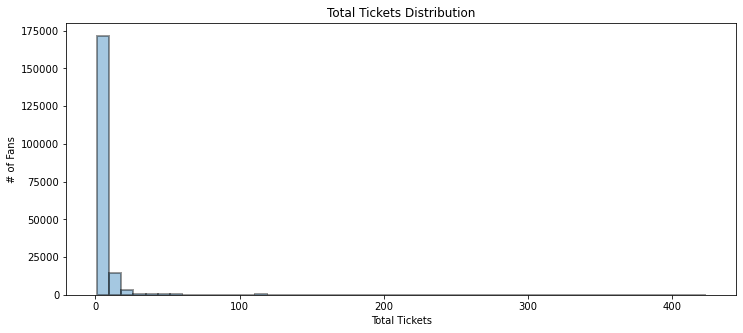

In [16]:
plt.figure(figsize=(12,5))
sns.distplot(analysis_data["total_tickets"],hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Tickets Distribution')
plt.xlabel('Total Tickets')
plt.ylabel('# of Fans')
plt.show()

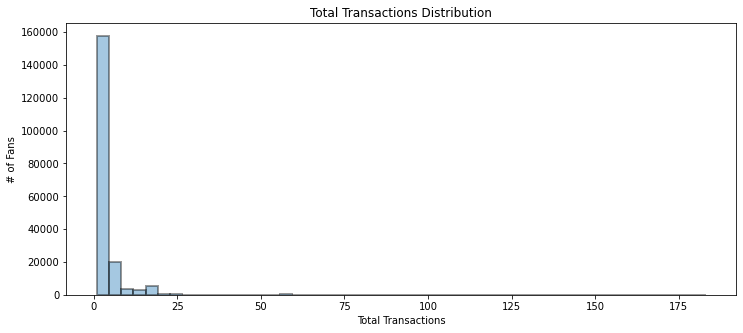

In [17]:
plt.figure(figsize=(12,5))
sns.distplot(analysis_data["total_transactions"],hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Transactions Distribution')
plt.xlabel('Total Transactions')
plt.ylabel('# of Fans')
plt.show()

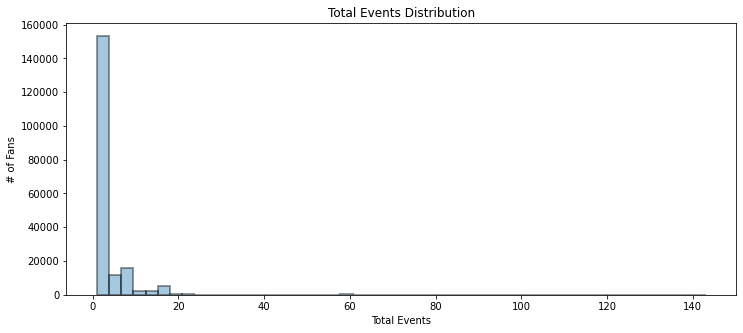

In [18]:
plt.figure(figsize=(12,5))
sns.distplot(analysis_data["total_events"],hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Events Distribution')
plt.xlabel('Total Events')
plt.ylabel('# of Fans')
plt.show()

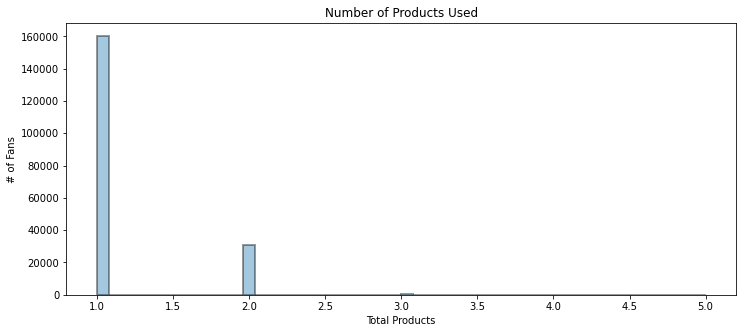

In [19]:
plt.figure(figsize=(12,5))
sns.distplot(analysis_data["num_products_used"],hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Number of Products Used')
plt.xlabel('Total Products')
plt.ylabel('# of Fans')
plt.show()

## Lots of skewed data need to fix  by transforming data before cluster analysis


### Box-Cox transformations applied to help normalize the data
<font color=blue> Creating a copy of "analysis_data" called "fans_fix" to work with</font>

In [20]:
from scipy import stats
fans_fix = analysis_data.copy()
fans_fix["total_net_sales_transformed"] = stats.boxcox(fans_fix['total_net_sales'])[0]
fans_fix["total_tickets_transformed"] = stats.boxcox(fans_fix['total_tickets'])[0]
fans_fix["num_products_used_transformed"] = stats.boxcox(fans_fix['num_products_used'])[0]
fans_fix["total_events_transformed"] = stats.boxcox(fans_fix['total_events'])[0]

#fans_fix["column name"] = pd.Series(np.cbrt(fans_fix['column name'])).values -- use if negative values

fans_fix.tail()

,index,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,...,total_net_sales,total_credit_given,total_tickets,total_transactions,total_events,num_products_used,total_net_sales_transformed,total_tickets_transformed,num_products_used_transformed,total_events_transformed
191779,369732,4650029,NCAA BB,1652,5,0,0,0,1,0,...,10.0,0.0,2.0,1,1,1,2.152533,0.607927,0.0,0.000000
191780,369733,5120718,MLB,24,1,1,0,0,0,0,...,106.0,0.0,4.0,1,1,1,4.075036,1.072762,0.0,0.000000
191781,369736,2541881,LIVE NATION,149,12,1,0,0,0,0,...,40.0,0.0,2.0,1,1,1,3.313850,0.607927,0.0,0.000000
191782,369737,4128436,NCAA BB,966,5,0,0,0,1,0,...,22.0,0.0,2.0,2,2,1,2.824700,0.607927,0.0,0.467266
191783,369742,2396762,MLB,31,1,1,0,0,0,0,...,13.0,0.0,1.0,1,1,1,2.379693,0.000000,0.0,0.000000


## Checking the normality of data after transformations

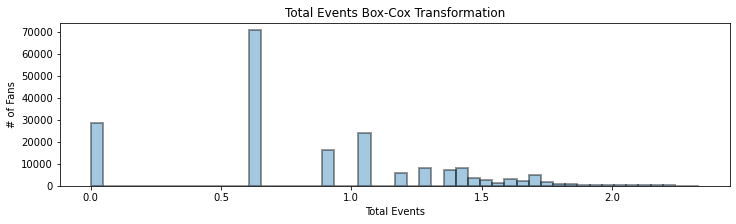

In [21]:
plt.figure(figsize=(12,3))
sns.distplot(fans_fix["total_tickets_transformed"] ,hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Events Box-Cox Transformation')
plt.xlabel('Total Events')
plt.ylabel('# of Fans')
plt.show()

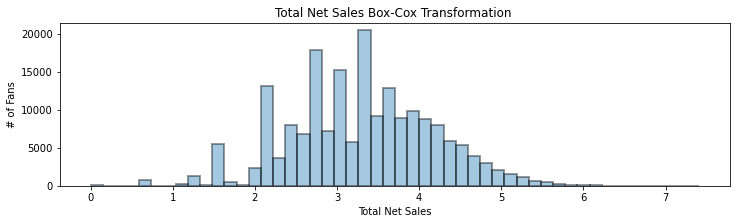

In [22]:
plt.figure(figsize=(12,3))
sns.distplot(fans_fix["total_net_sales_transformed"] ,hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Net Sales Box-Cox Transformation ')
plt.xlabel('Total Net Sales')
plt.ylabel('# of Fans')
plt.show()

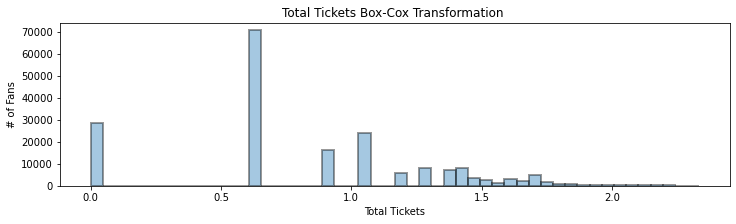

In [23]:
plt.figure(figsize=(12,3))
sns.distplot(fans_fix["total_tickets_transformed"] ,hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Tickets Box-Cox Transformation ')
plt.xlabel('Total Tickets')
plt.ylabel('# of Fans')
plt.show()

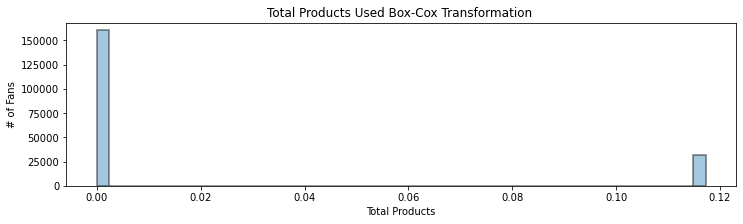

In [24]:
plt.figure(figsize=(12,3))
sns.distplot(fans_fix["num_products_used_transformed"] ,hist_kws=dict(edgecolor="k", linewidth=2),kde=False,bins=50)
plt.title('Total Products Used Box-Cox Transformation ')
plt.xlabel('Total Products')
plt.ylabel('# of Fans')
plt.show()

### Reducing columns to those only needed for Segmentation using K-Means 

In [25]:
fans_fix_trim = fans_fix[["total_tickets_transformed","total_net_sales_transformed","total_events_transformed","num_products_used_transformed"]]
fans_fix_trim

,total_tickets_transformed,total_net_sales_transformed,total_events_transformed,num_products_used_transformed
0,1.828211,4.238126,0.778059,0.117237
1,1.944643,2.502113,0.794853,0.116930
2,1.773020,2.152533,0.796207,0.000000
3,2.321118,6.587227,0.810905,0.117237
4,2.141620,5.652365,0.809944,0.116930
...,...,...,...,...
191779,0.607927,2.152533,0.000000,0.000000
191780,1.072762,4.075036,0.000000,0.000000
191781,0.607927,3.313850,0.000000,0.000000
191782,0.607927,2.824700,0.467266,0.000000


### Normalize the data using StandardScaler object from scikit-learn library

In [26]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize scaler 
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(fans_fix_trim)
fans_normalized = scaler.transform(fans_fix_trim)
# Assert that it has mean 0 and variance 1
print(fans_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(fans_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0.  0. -0. -0.]
[1. 1. 1. 1.]


In [27]:
print(fans_normalized)

[[ 1.94166694  1.07313341  1.69948981  2.26093605]
 [ 2.17071701 -0.90989132  1.75254246  2.2538441 ]
 [ 1.83309421 -1.30921227  1.75681869 -0.44365784]
 ...
 [-0.45891206  0.01734483 -0.75839484 -0.44365784]
 [-0.45891206 -0.54140528  0.71769554 -0.44365784]
 [-1.6548447  -1.04973045 -0.75839484 -0.44365784]]


## K-Means using scikit-learn

### Determining the number of Clusters to use via Elbow Method

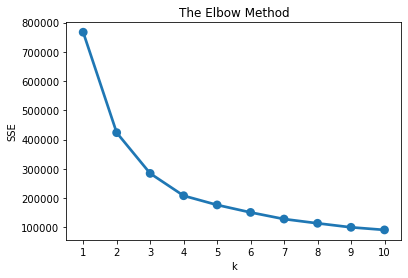

In [28]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(fans_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


### The x-axis is the value of k , and the y-axis is the SSE value of the data. 

### Take the best parameter by determining where k-value will have a linear trend on next consecutive k. 


### the k-value of 4 is the best hyperparameter for the model because the next k-value tends to have a linear trend after k = 4 .  

### I ran the analysis using 4 clusters 

In [29]:
# Fitting the model

model = KMeans(n_clusters=4, random_state=42)
model.fit(fans_normalized)
model.labels_.shape

(191784,)

## Summarize the segmentation table based on clusters and calculate the mean of each variable. 

In [30]:
fans_fix_trim["Cluster"] = model.labels_
fans_fix_trim.groupby('Cluster').agg({
    'num_products_used_transformed':'mean',
    'total_tickets_transformed':'mean',
    'total_net_sales_transformed':'mean',
    'total_events_transformed':['mean', 'count']}).round(2)

num_products_used_transformed total_tickets_transformed  \
                                 mean                      mean   
Cluster                                                           
0                                0.00                      0.31   
1                                0.12                      1.44   
2                                0.00                      1.26   
3                                0.00                      0.73   

        total_net_sales_transformed total_events_transformed         
                               mean                     mean  count  
Cluster                                                              
0                              2.45                     0.02  51387  
1                              3.12                     0.70  29308  
2                              3.86                     0.59  41562  
3                              3.67                     0.00  69527

### We can analyze the segments using snake plot. It requires the normalized dataset and also the cluster labels. By using this plot, we can have a good visualization from the data on how the cluster differs from each other. 

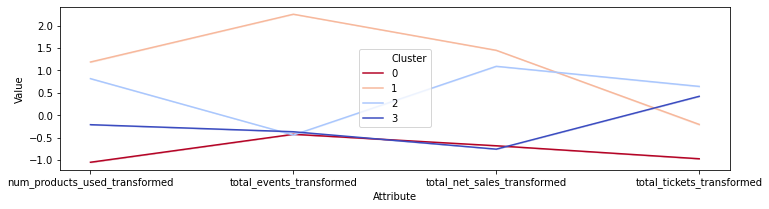

In [31]:
# Create the dataframe
df_normalized = pd.DataFrame(fans_normalized, columns=['num_products_used_transformed','total_tickets_transformed','total_net_sales_transformed', 'total_events_transformed'])
df_normalized['ID'] = fans_fix_trim.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID','Cluster'],
                      value_vars=['num_products_used_transformed','total_tickets_transformed','total_net_sales_transformed','total_events_transformed'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
plt.figure(figsize=(12,3))

sns.lineplot('Attribute', 'Value', hue='Cluster', palette="coolwarm_r",data=df_nor_melt)
plt.show()

# This snake plot above shows how each cluster differs across the attributes:


<font color=blue>Cluster 0 fans use few products, attend few events, spend little and use little tickets. <br>
Cluster 1 fans have high product usage, attend the most events, have the highest sales and medium ticket usage  <br>
Cluster 2 fans have higher product usage, attend few events and spend more and use more tickets. <br>
Cluster 3 fans have low product usage, attend few events and low spend and high ticket usage
 </font>


### Normalized dataset will need to merge back to original data

In [32]:

df_normalized

,num_products_used_transformed,total_tickets_transformed,total_net_sales_transformed,total_events_transformed,ID,Cluster
0,1.941667,1.073133,1.699490,2.260936,0,1
1,2.170717,-0.909891,1.752542,2.253844,1,1
2,1.833094,-1.309212,1.756819,-0.443658,2,2
3,2.911330,3.756480,1.803250,2.260936,3,1
4,2.558215,2.688599,1.800215,2.253844,4,1
...,...,...,...,...,...,...
191779,-0.458912,-1.309212,-0.758395,-0.443658,191779,0
191780,0.455525,0.886838,-0.758395,-0.443658,191780,3
191781,-0.458912,0.017345,-0.758395,-0.443658,191781,3
191782,-0.458912,-0.541405,0.717696,-0.443658,191782,0


## Join normalized dataframe to original dataframe to get cluster grouping 

In [33]:
recombined_data = analysis_data.join(df_normalized)

In [34]:
recombined_data.drop(['index'], axis=1)

,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,fluid_ticket_fan,...,total_tickets,total_transactions,total_events,num_products_used,num_products_used_transformed,total_tickets_transformed,total_net_sales_transformed,total_events_transformed,ID,Cluster
0,83025,NBA,1047,3,1,0,1,0,0,1,...,24.0,12,12,3,1.941667,1.073133,1.699490,2.260936,0,1
1,252070,NCAA BB,665,5,1,0,1,0,0,0,...,37.0,35,19,2,2.170717,-0.909891,1.752542,2.253844,1,1
2,555476,NCAA BB,1161,5,0,0,1,0,0,0,...,20.0,20,20,1,1.833094,-1.309212,1.756819,-0.443658,2,2
3,906123,NBA,1047,3,0,0,1,1,0,1,...,370.0,54,54,3,2.911330,3.756480,1.803250,2.260936,3,1
4,1107319,NBA,1047,3,1,0,1,0,0,0,...,96.0,48,48,2,2.558215,2.688599,1.800215,2.253844,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191779,4650029,NCAA BB,1652,5,0,0,0,1,0,0,...,2.0,1,1,1,-0.458912,-1.309212,-0.758395,-0.443658,191779,0
191780,5120718,MLB,24,1,1,0,0,0,0,0,...,4.0,1,1,1,0.455525,0.886838,-0.758395,-0.443658,191780,3
191781,2541881,LIVE NATION,149,12,1,0,0,0,0,0,...,2.0,1,1,1,-0.458912,0.017345,-0.758395,-0.443658,191781,3
191782,4128436,NCAA BB,966,5,0,0,0,1,0,0,...,2.0,2,2,1,-0.458912,-0.541405,0.717696,-0.443658,191782,0


## Cluster Stats

In [35]:
clustered_stats = recombined_data[["Cluster","total_net_sales","total_tickets","total_events","num_products_used",\
                                  "total_net_sales_transformed","total_events_transformed","total_events_transformed","num_products_used_transformed"]]

In [36]:
# Group by Cluster
by_cluster = clustered_stats.groupby("Cluster")

In [37]:
# Average of Metrics by Cluster
by_cluster.mean()

,total_net_sales,total_tickets,total_events,num_products_used,total_net_sales_transformed,total_events_transformed,total_events_transformed,num_products_used_transformed
Cluster,,,,,,,,
0,16.819992,1.547434,1.053457,1.006597,-0.682577,-0.426491,-0.426491,-1.050755
1,86.521472,13.219121,9.714924,2.021769,1.448410,2.253807,2.253807,1.187435
2,142.224112,8.005269,4.296256,1.000000,1.091131,-0.443658,-0.443658,0.816164
3,82.525608,2.580321,1.000058,1.027773,-0.758325,-0.369629,-0.369629,-0.211825


In [38]:
# of Customers in each Cluster
clustered_stats['Cluster'].value_counts()

3    69527
0    51387
2    41562
1    29308
Name: Cluster, dtype: int64

In [39]:
# Drop index column 

Clustered_Fans = recombined_data.reset_index(drop=True)

In [40]:
Clustered_Fans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191784 entries, 0 to 191783
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   index                            191784 non-null  int64  
 1   fan_id                           191784 non-null  int64  
 2   segment                          191784 non-null  object 
 3   group_id                         191784 non-null  int64  
 4   group_type_id                    191784 non-null  int64  
 5   upgrade_fan                      191784 non-null  int64  
 6   exp_merch_fan                    191784 non-null  int64  
 7   pass_fan                         191784 non-null  int64  
 8   pass_one_fan                     191784 non-null  int64  
 9   pass_select_fan                  191784 non-null  int64  
 10  fluid_ticket_fan                 191784 non-null  int64  
 11  pass_linkage_user                191784 non-null  int64  
 12  pa

### Categorizing the Clusters values into Personas that describe them

In [41]:

def label_Cluster (row):
   if row['Cluster'] == 0 :
      return 'Frugal Attendees'
   if row['Cluster'] == 1:
      return 'Enthusiastic Loyalists'
   if row['Cluster'] == 2 :
      return 'Access Spenders'
   if row['Cluster'] == 3:
      return 'One-Time Experience'
   

In [42]:
Clustered_Fans.apply (lambda row: label_Cluster(row), axis=1)

0         Enthusiastic Loyalists
1         Enthusiastic Loyalists
2                Access Spenders
3         Enthusiastic Loyalists
4         Enthusiastic Loyalists
                   ...          
191779          Frugal Attendees
191780       One-Time Experience
191781       One-Time Experience
191782          Frugal Attendees
191783          Frugal Attendees
Length: 191784, dtype: object

In [43]:
Clustered_Fans['Persona'] = Clustered_Fans.apply (lambda row: label_Cluster(row), axis=1)

In [44]:
Clustered_Fans.drop("index",axis=1)

,fan_id,segment,group_id,group_type_id,upgrade_fan,exp_merch_fan,pass_fan,pass_one_fan,pass_select_fan,fluid_ticket_fan,...,total_transactions,total_events,num_products_used,num_products_used_transformed,total_tickets_transformed,total_net_sales_transformed,total_events_transformed,ID,Cluster,Persona
0,83025,NBA,1047,3,1,0,1,0,0,1,...,12,12,3,1.941667,1.073133,1.699490,2.260936,0,1,Enthusiastic Loyalists
1,252070,NCAA BB,665,5,1,0,1,0,0,0,...,35,19,2,2.170717,-0.909891,1.752542,2.253844,1,1,Enthusiastic Loyalists
2,555476,NCAA BB,1161,5,0,0,1,0,0,0,...,20,20,1,1.833094,-1.309212,1.756819,-0.443658,2,2,Access Spenders
3,906123,NBA,1047,3,0,0,1,1,0,1,...,54,54,3,2.911330,3.756480,1.803250,2.260936,3,1,Enthusiastic Loyalists
4,1107319,NBA,1047,3,1,0,1,0,0,0,...,48,48,2,2.558215,2.688599,1.800215,2.253844,4,1,Enthusiastic Loyalists
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191779,4650029,NCAA BB,1652,5,0,0,0,1,0,0,...,1,1,1,-0.458912,-1.309212,-0.758395,-0.443658,191779,0,Frugal Attendees
191780,5120718,MLB,24,1,1,0,0,0,0,0,...,1,1,1,0.455525,0.886838,-0.758395,-0.443658,191780,3,One-Time Experience
191781,2541881,LIVE NATION,149,12,1,0,0,0,0,0,...,1,1,1,-0.458912,0.017345,-0.758395,-0.443658,191781,3,One-Time Experience
191782,4128436,NCAA BB,966,5,0,0,0,1,0,0,...,2,2,1,-0.458912,-0.541405,0.717696,-0.443658,191782,0,Frugal Attendees


## Persona Visualizations

In [45]:
by_cluster = Clustered_Fans.groupby("Persona")

In [46]:
by_cluster['total_net_sales'].mean()

Persona
Access Spenders           142.224112
Enthusiastic Loyalists     86.521472
Frugal Attendees           16.819992
One-Time Experience        82.525608
Name: total_net_sales, dtype: float64

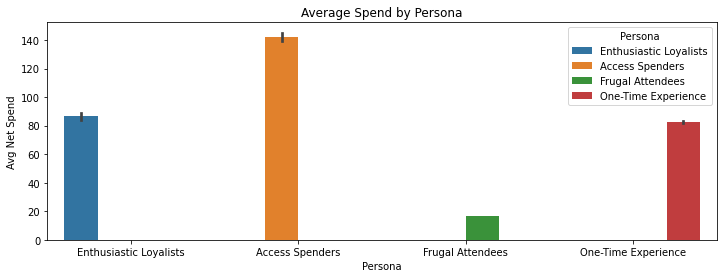

In [47]:
plt.figure(figsize=(12,4))
sns.barplot(x='Persona',y='total_net_sales',hue='Persona',data=Clustered_Fans)
plt.title('Average Spend by Persona')
plt.xlabel("Persona")
plt.ylabel("Avg Net Spend")
plt.show()

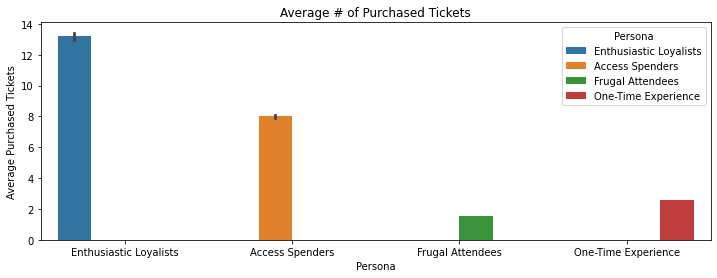

In [48]:
plt.figure(figsize=(12,4))
sns.barplot(x='Persona',y='total_tickets',hue='Persona',data=Clustered_Fans)
plt.title('Average # of Purchased Tickets')
plt.xlabel("Persona")
plt.ylabel("Average Purchased Tickets")
plt.show()

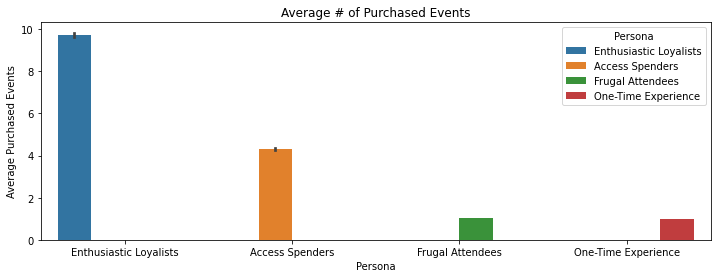

In [49]:
plt.figure(figsize=(12,4))
sns.barplot(x='Persona',y='total_events',hue='Persona',data=Clustered_Fans)
plt.title('Average # of Purchased Events')
plt.xlabel("Persona")
plt.ylabel("Average Purchased Events")
plt.show()

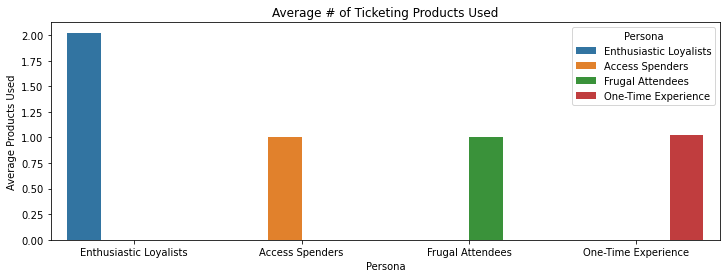

In [50]:
plt.figure(figsize=(12,4))
sns.barplot(x='Persona',y='num_products_used',hue='Persona',data=Clustered_Fans)
plt.title('Average # of Ticketing Products Used')
plt.xlabel("Persona")
plt.ylabel("Average Products Used")
plt.show()

### Distribution of Customers by Persona

In [51]:
Access_Spenders = Clustered_Fans[Clustered_Fans['Persona'] =='Access Spenders']['fan_id'].count()
Enthusiastic_Loyalists = Clustered_Fans[Clustered_Fans['Persona'] =='Enthusiastic Loyalists']['fan_id'].count()
Frugal_Attendees = Clustered_Fans[Clustered_Fans['Persona'] =='Frugal Attendees']['fan_id'].count()
One_Time_Experience = Clustered_Fans[Clustered_Fans['Persona'] =='One-Time Experience']['fan_id'].count()
Total_pop = Access_Spenders + Enthusiastic_Loyalists + Frugal_Attendees + One_Time_Experience

In [54]:
fan_count = [Access_Spenders,Enthusiastic_Loyalists,Frugal_Attendees,One_Time_Experience]# List of fan_count values
names =['Access Spenders','Enthusiastic Loyalists', 'Frugal Attendees','One-Time Experience']# Names to go with counts

In [55]:
# Making this into a dataframe to summarize for pie chart below
df = pd.DataFrame(all,index=names, columns=['fan_count'])

In [56]:
df

,fan_count
Access Spenders,41562
Enthusiastic Loyalists,29308
Frugal Attendees,51387
One-Time Experience,69527


### Pie Chart showing the Persona Breakdown 

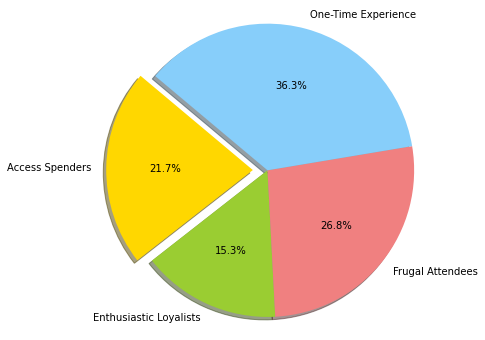

In [59]:
# Data to plot
labels = names
sizes = all
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Export data to csv file

## Key Takeaways

### 1. Enthusiastic Loyalists and Access Spenders are the most engaged fans that purchase our products
### 2. Frugal Attendees and One-Time Experience Fans exhibit similar behaviors but the One-Timers tend to spend more than the frugal attendees
### 3. More work should be done to market to the Frugal Attendees and One-Time Experience to promote the benefits of using our products maybe offering promotions to encourage more utilization
### 4.  More effort should be spent on keeping the Access Spenders and Enthusiastic Loyalists engaged with our products perhaps encouraging the Access Spenders to utilize more of our availble ticketing products as the Loyalists already do.  Maybe start a promotion to award perks for recommending new customers?

In [42]:
# Export data to csv file

Clustered_Fans.to_csv("Clustered Fans Output.csv", index = False)